# ASTR6002 - Galaxies and Cosmology Assignment 3
## Question 2: Finding the cosmological parameters of our Universe from type-Ia supernovae
Cyrus Worley, Kritika Halder, Nadir Yudoputra

Code for analyzing the `jla.csv` file of supernovae distance modulus and redshift data.

In [249]:
# necessary modules
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from scipy.integrate import simpson
import cosmocalc

In [250]:
# import data from csv file as structured ndarray
data = np.genfromtxt("jla.csv", dtype=None, names=True, delimiter=",")
data = np.sort(data, order='z')

Text(0.5, 1.0, 'Supernovae distance modulus vs redshift')

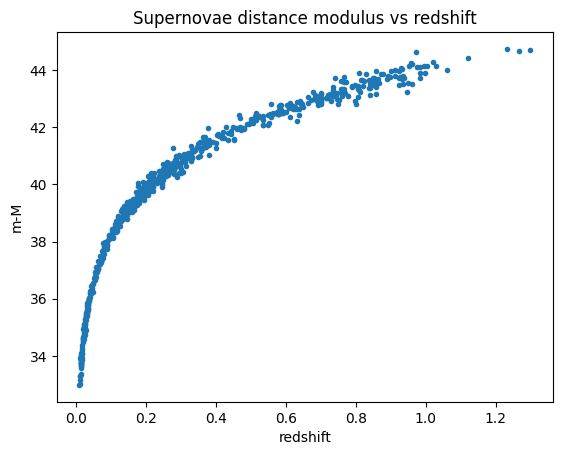

In [251]:
# plot just the supernovae data by itself (distance mod vs redshift)
plt.plot(data['z'], data['mu'], ".")

plt.xlabel("redshift")
plt.ylabel("m-M")
plt.title("Supernovae distance modulus vs redshift")

Analytical and numerical methods of calculating the distance modulus from redshift are both available with this function `mod_predict()`.

#### Analytical Distance Modulus
Matter-only analytical distance modulus ($\Omega_{M,0}=1$, $\Omega_{\Lambda,0}=0$):
$$
(m-M)_{\text{M}} = 25 + 5\left[ \log_{10}\left( \frac{2c}{H_{0}} \right) + \log_{10}(z+1) + \log_{10}\left( 1-\frac{1}{\sqrt{ z+1 }} \right)\right]
$$

Lambda-only analytical distance modulus ($\Omega_{M,0}=0$, $\Omega_{\Lambda,0}=1$):
$$
(m-M)_{\Lambda} = 25 + 5\left[ \log_{10}\left( \frac{c}{H_{0}} \right) + \log_{10}(z+1) + \log_{10}(z)\right]
$$

Empty* universe analytical distance modulus ($\Omega_{M,0}=0$, $\Omega_{\Lambda,0}=0$):
$$
(m-M)_{\text{0}} = 25 + 5\left[ \log_{10}\left( \frac{c}{H_{0}} \right) + \log_{10}(z+1) + \log_{10}(\ln(z+1))\right]
$$

*technically this one isn't possible with the method of calculating luminosity distance from proper distance with $D_{L}=D_{P}(1+z)$, since an empty universe is not flat.

#### Numerical Distance Modulus

Distance modulus can be numerically calculated by integrating to find the co-moving distance at a given redshift, which can then be used to find the luminosity distance. This integration can be done in two ways, with the `simpson` method from `scipy.integrate`, or with the Euler method (over lookback time instead of redshift) from `cosmocalc.py` created for Question 1. 

Using `cosmocalc`:
1. Obtain luminosity distance and redshift arrays from `cosmocalc` integrations (Euler method, see question 1 for details)
2. Calculate distance modulus from luminosity distance using $m - M = 5 \log_{10}\left[\frac{D_L(z)}{Mpc}\right] + 25$

Using `scipy.integrate`:
1. Generate a range of redshift values from 0 (now) to $z$ (input redshift) to integrate over
2. Obtain the behavior of each density parameter over that redshift range, based on the initial density parameters $\Omega_{0}$
3. Write the Hubble parameter $H(z)$ in terms of these changing density parameters
4. Integrate to find the proper distance between observer at $z=0$ and input $z$ using `scipy.integrate`: $D_P(z) = c \int_{z}^{0} \frac{1}{H(z')} dz'$
5. Find luminosity distance at $z$ with $D_L(z) = (1 + z) D_P(z)$
6. Convert $D_L(z)$ to distance modulus: $m - M = 5 \log_{10}\left[\frac{D_L(z)}{Mpc}\right] + 25$
7. Repeat for each redshift in an array to generate a full prediction for distance modulus in a particular cosmological model

The `scipy` integration method over redshift is heavily inspired by previous coursework with Dr. Gurtina Besla (University of Arizona).

In [252]:
def mod_predict(z, OmegaM0, OmegaL0, OmegaR0=0, d_luminosity=None, H0=70.0, num=False):
    """ Computes the distance modulus at a given redshift for a chosen cosmological model,
    using analytical or numerical methods.
    
    PARAMETERS
    ----------
        z: `float`
            redshift to calculate distance modulus at
        OmegaM0: `float`
            initial cosmological matter density (from 0 to 1)
        OmegaL0: `float`
            initial cosmological lambda density (from 0 to 1)
        OmegaR0: `float`
            initial cosmological radiation density (from 0 to 1, default = 0)
        H0: `float`
            current value of Hubble parameter at z=0 (default = 70.0 km/s/Mpc)
        num: `boolean`
            controls whether numerical methods are used for empty, matter-only, and
            lambda-only models (default = False)
        
    RETURNS
    -------
        modulus: `float`
            distance modulus at redshift z
    """
    
    c_kms = c.to_value(u.km/u.s)
    
    # matter only
    if (OmegaM0 == 1.0) & (OmegaL0 == 0.0) & (num == False):
        factor = np.log10(2*c_kms / H0)
        factor2 = np.log10( 1 - 1/np.sqrt(z + 1)) + np.log10(1+z)
        return 25.5 + 5 * (factor + factor2)
        
    # lambda only
    if (OmegaM0==0.0) & (OmegaL0==1.0) & (num == False):
        factor = np.log10(c_kms / H0)
        factor2 = np.log10(z) + np.log10(z+1)
        return 25.5 + 5 * (factor + factor2)
    
    # empty
    if (OmegaM0 == 0.0) & (OmegaL0 == 0.0) & (num == False):
        factor = np.log10(c_kms / H0)
        factor2 =  np.log10(z+1) + np.log10(np.log(1+z))
        return 25.5 + 5 * (factor + factor2)
    

    # range of z to integrate over (from 0 to input)
    zrange = np.arange(0, z, 1e-3)
    
    # density parameter evolution over zrange
    OmegaM = OmegaM0*(1+zrange)**3
    OmegaR = OmegaR0*(1+zrange)**4
    OmegaL = OmegaL0
    OmegaK = (1 - (OmegaM0+OmegaR0+OmegaL0))*(1+zrange)**2
    
    # hubble parameter
    Hz = H0 * np.sqrt(OmegaM + OmegaR + OmegaL + OmegaK)
    
    # proper distance
    y = c_kms * (1 / Hz)
    DC = simpson(y, x=zrange) * u.Mpc
    
    # luminosity distance
    DL = DC * (1 + z)
    # distance modulus
    return 25 + 5 * np.log10(DL/u.Mpc)


In [253]:
def dist_to_mod(dist):
    """Simple distance modulus equation
    m-M = 25 + 5 * log10 (dist/10Mpc)
    """
    
    return 25 + 5 * np.log10(dist)

### Analytical Analysis

In [254]:
# generating analytical distance modulus predictions for each single-component universe
h0 = 70
empty_mod = np.asarray([mod_predict(i, 0, 0, H0=h0) for i in data['z']])
matter_mod = np.asarray([mod_predict(i, 1, 0, H0=h0) for i in data['z']])
lambda_mod = np.asarray([mod_predict(i, 0, 1, H0=h0) for i in data['z']])

In [255]:
# benchmark has to be handled differently

# scipy method (integration for each z)
benchmark_mod_simpson = np.asarray([mod_predict(i, 0.3, 0.7, H0=h0) for i in data['z']])

# cosmology calculator
hubble = (h0 * (u.km / u.s / u.Mpc)).to(1 / u.Gyr).value
benchmark = cosmocalc.cosmology_calc(0.01, 0.3, 0.7, hubble)
benchmark_mod = dist_to_mod(benchmark.d_luminosity)

/tmp/ipykernel_111008/3456714509.py:6: RuntimeWarning: divide by zero encountered in log10
  return 25 + 5 * np.log10(dist)


In [256]:
# truncate benchmark arrays to the same redshift as the data
maximum = np.max(data['z'])
print(maximum)

benchmark_z = benchmark.redshift[benchmark.redshift < maximum]
benchmark_modulus = benchmark_mod[:benchmark_z.shape[0]]

1.2991


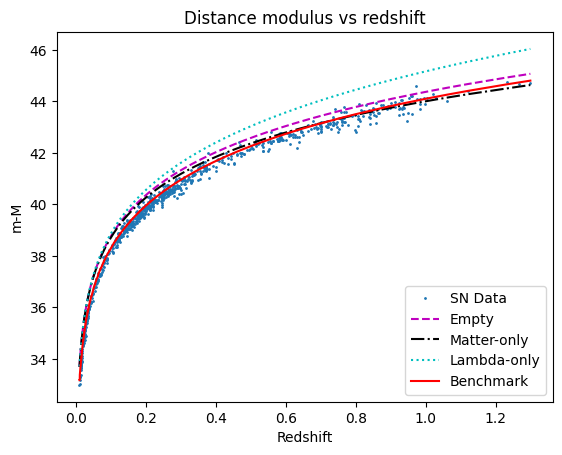

In [257]:
# plot analytical predictions on top of SN data
plt.plot(data['z'], data['mu'], ".", markersize=2, label="SN Data")

# single-component
plt.plot(data['z'], empty_mod, "--m", label="Empty")
plt.plot(data['z'], matter_mod, "-.k", label="Matter-only")
plt.plot(data['z'], lambda_mod, ":c", label="Lambda-only")

# benchmark
plt.plot(data['z'], benchmark_mod_simpson, "-r", label="Benchmark")
#plt.plot(benchmark_z, benchmark_modulus, "-r", label="Benchmark")

plt.xlabel("Redshift")
plt.ylabel("m-M")
plt.title("Distance modulus vs redshift")
plt.legend(loc="lower right")

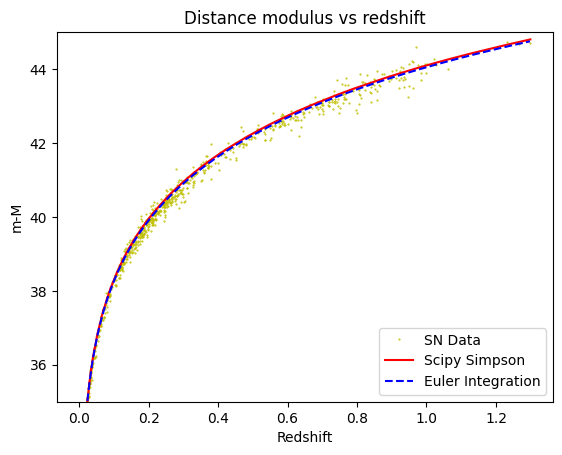

In [258]:
# comparing benchmark methods
plt.plot(data['z'], data['mu'], ".y", markersize=1, label="SN Data")
plt.plot(data['z'], benchmark_mod_simpson, "-r", label="Scipy Simpson")
plt.plot(benchmark_z, benchmark_modulus, "--b", label="Euler Integration")

plt.xlabel("Redshift")
plt.ylabel("m-M")
plt.ylim(35.0, 45.0)
plt.title("Distance modulus vs redshift")
plt.legend(loc="lower right")

### Residuals and Chi-Squared

Each distance modulus prediction and the initial data has the empty-universe prediction subtracted from it.

The Euler-integrated distance modulus data requires a new set of empty-universe predictions to be generated of the same shape as the benchmark redshift array.

/tmp/ipykernel_111008/2260848407.py:44: RuntimeWarning: divide by zero encountered in log10
  factor2 =  np.log10(z+1) + np.log10(np.log(1+z))
/tmp/ipykernel_111008/1433432637.py:9: RuntimeWarning: invalid value encountered in subtract
  bench_resids  = benchmark_modulus - empty_bench_mod


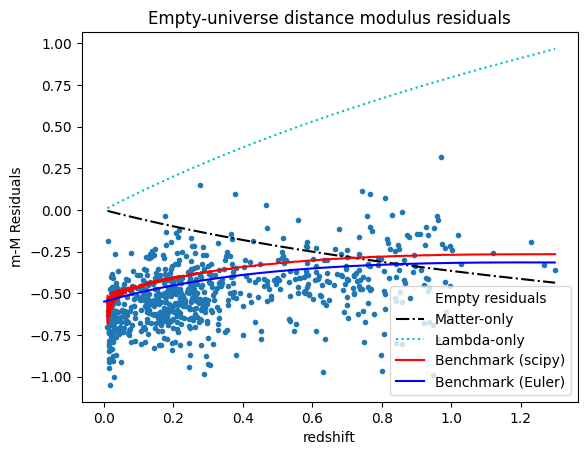

In [259]:
# residuals of distance mod
empty_resids = data['mu'] - empty_mod
matter_resids = matter_mod - empty_mod
lambda_resids = lambda_mod - empty_mod
bench_resids_simpson = benchmark_mod_simpson - empty_mod

# make empty universe modulus from benchmark array shape
empty_bench_mod = np.asarray([mod_predict(i, 0, 0, H0=h0) for i in benchmark_z])
bench_resids  = benchmark_modulus - empty_bench_mod

plt.plot(data['z'], empty_resids, ".", label="Empty residuals")
plt.plot(data['z'], matter_resids, "-.k", label="Matter-only")
plt.plot(data['z'], lambda_resids, ":c", label="Lambda-only")
plt.plot(data['z'], bench_resids_simpson, "-r", label="Benchmark (scipy)")
plt.plot(benchmark_z, bench_resids, "-b", label="Benchmark (Euler)")

plt.xlabel("redshift")
plt.ylabel("m-M Residuals")
plt.title("Empty-universe distance modulus residuals")
plt.legend()

#### Reduced Chi Squared

Best fit is determined by the reduced chi-squared sum:
$$ \chi_{red}^2 = \frac{1}{n-f}\sum^n_{i}\frac{(x_{i}-\mu)^2}{\sigma_i^2} $$
with parameters:
- $x_i$: SN distance modulus data at redshift $z_i$
- $\mu$: predicted distance modulus at redshift $z_i$
- $\sigma$: error in SN distance modulus at redshift $z_i$
- $n$: number of SN data points
- $f$: degrees of freedom (2)

In [260]:
def chisquared(model, data, data_err, dof=2):
    """ returns reduced chi squared metric of best fit for a model and data

        PARAMETERS
        ----------
        model: `ndarray`
            array with model to compare to data
        data: `ndarray`
            array with data to compare to model
        data_err: `ndarray` or `float`
            error in data
        dof: `int`
            degrees of freedom in model (default = 2)
        
        RETURNS
        -------
        chisqu: `float`
            reduced chi squared sum

    """
    
    resid_sq = (model - data)**2
    chi_components = resid_sq / data_err**2
    
    chisqu = np.sum(chi_components)
    return chisqu / (len(data) - dof)
    

In [261]:
# chisquared for each model
chi_empty = chisquared(empty_mod, data['mu'], data['dmu'], 2)
print(f"Empty Reduced chi squared: {chi_empty:.4f}")

chi_lambda = chisquared(lambda_mod, data['mu'], data['dmu'], 2)
print(f"Lambda-only Reduced chi squared: {chi_lambda:.4f}")

chi_matter = chisquared(matter_mod, data['mu'], data['dmu'], 2)
print(f"Matter-only Reduced chi squared: {chi_matter:.4f}")

chi_benchmark = chisquared(benchmark_mod_simpson, data['mu'], data['dmu'], 2)
print(f"M=0.3, L=0.7 Reduced chi squared: {chi_benchmark:.4f}")

Empty Reduced chi squared: 11.0194
Lambda-only Reduced chi squared: 24.2383
Matter-only Reduced chi squared: 7.5660
M=0.3, L=0.7 Reduced chi squared: 1.2965


### Numerical Analysis

Same methods as before but using the numerical function to evaluate distance modulus for the empty, matter-only, and lambda-only universes (Benchmark stays the same).

In [262]:
# numerical distance modulus arrays
empty_mod_num = np.asarray([mod_predict(i, 0, 0, num=True) for i in data['z']])
matter_mod_num = np.asarray([mod_predict(i, 1, 0, num=True) for i in data['z']])
lambda_mod_num = np.asarray([mod_predict(i, 0, 1, num=True) for i in data['z']])

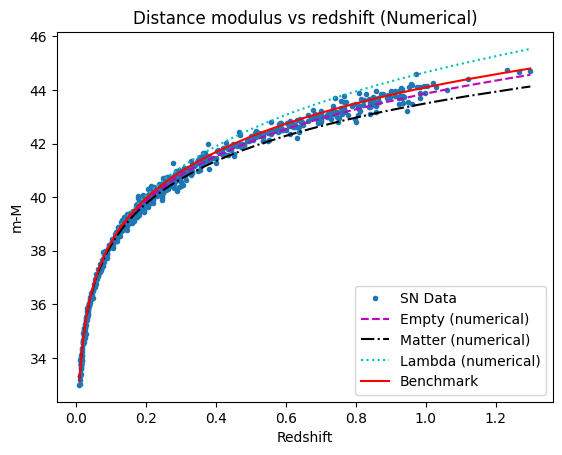

In [263]:
# plotting all numerical versions together

plt.plot(data['z'], data['mu'], ".", label="SN Data")

plt.plot(data['z'], empty_mod_num, "--m", label="Empty (numerical)")
plt.plot(data['z'], matter_mod_num, "-.k", label="Matter (numerical)")
plt.plot(data['z'], lambda_mod_num, ":c", label="Lambda (numerical)")
plt.plot(data['z'], benchmark_mod_simpson, "-r", label="Benchmark")

plt.xlabel("Redshift")
plt.ylabel("m-M")
plt.title("Distance modulus vs redshift (Numerical)")
plt.legend(loc="lower right")

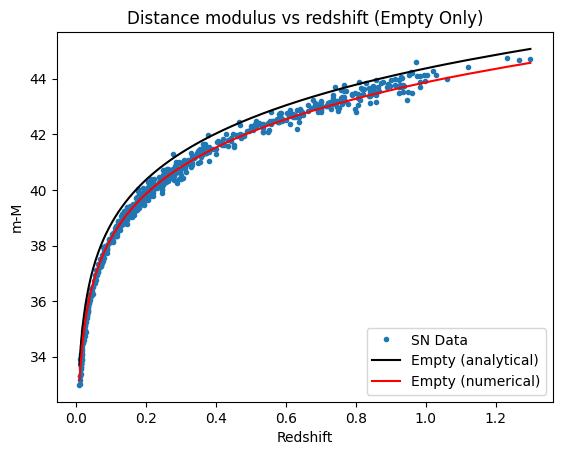

In [264]:
# plotting the two empty versions against each other

plt.plot(data['z'], data['mu'], ".", label="SN Data")

# empty
plt.plot(data['z'], empty_mod, "-k", label="Empty (analytical)")
plt.plot(data['z'], empty_mod_num, "-r", label="Empty (numerical)")

plt.xlabel("Redshift")
plt.ylabel("m-M")
plt.title("Distance modulus vs redshift (Empty Only)")
plt.legend(loc="lower right")

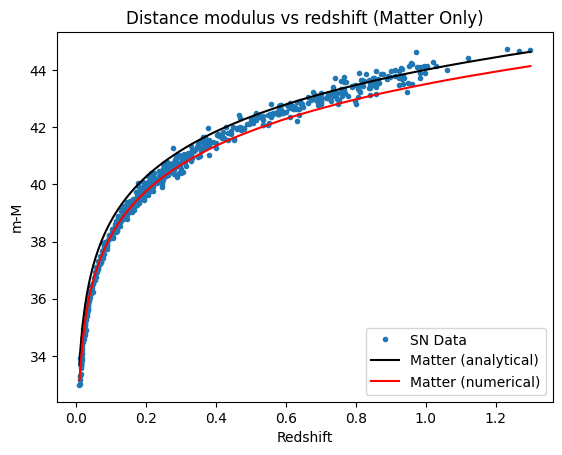

In [265]:
# plotting the two matter versions against each other

plt.plot(data['z'], data['mu'], ".", label="SN Data")

# matter
plt.plot(data['z'], matter_mod, "-k",     label="Matter (analytical)")
plt.plot(data['z'], matter_mod_num, "-r", label="Matter (numerical)")

plt.xlabel("Redshift")
plt.ylabel("m-M")
plt.title("Distance modulus vs redshift (Matter Only)")
plt.legend(loc="lower right")

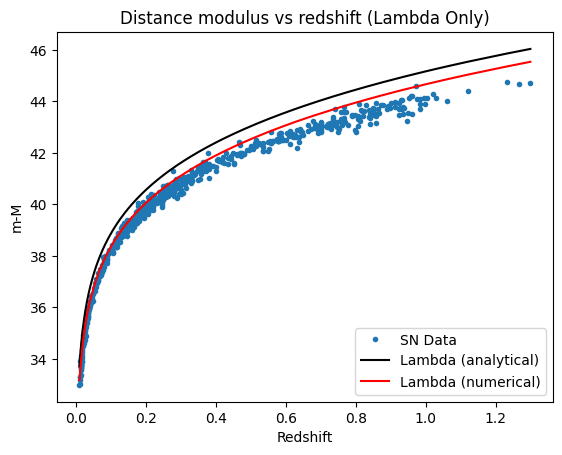

In [266]:
# plotting the two lambda versions against each other

plt.plot(data['z'], data['mu'], ".", label="SN Data")

# lambda
plt.plot(data['z'], lambda_mod, "-k",     label="Lambda (analytical)")
plt.plot(data['z'], lambda_mod_num, "-r", label="Lambda (numerical)")

plt.xlabel("Redshift")
plt.ylabel("m-M")
plt.title("Distance modulus vs redshift (Lambda Only)")
plt.legend(loc="lower right")

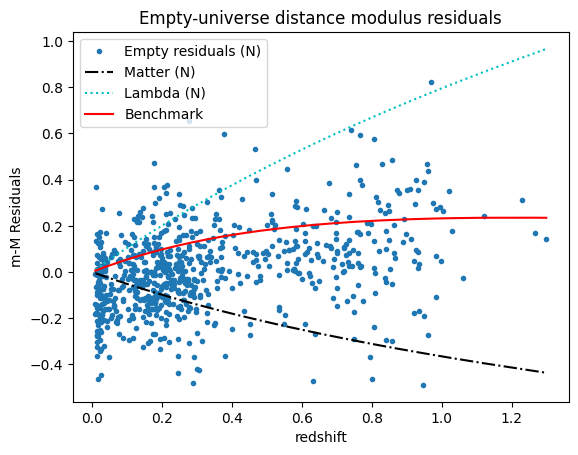

In [267]:
# numerical residuals of distance mod
empty_resids_num = data['mu'] - empty_mod_num
matter_resids_num = matter_mod_num - empty_mod_num
lambda_resids_num = lambda_mod_num - empty_mod_num
bench_resids_num = benchmark_mod_simpson - empty_mod_num

plt.plot(data['z'], empty_resids_num, ".", label="Empty residuals (N)")
plt.plot(data['z'], matter_resids_num, "-.k", label="Matter (N)")
plt.plot(data['z'], lambda_resids_num, ":c", label="Lambda (N)")
plt.plot(data['z'], bench_resids_num, "-r", label="Benchmark")

plt.xlabel("redshift")
plt.ylabel("m-M Residuals")
plt.title("Empty-universe distance modulus residuals")
plt.legend()

In [268]:
# chi-squared
print(f"Empty Reduced chi squared (analytical): {chi_empty:.4f}")
chi_empty_num = chisquared(empty_mod_num, data['mu'], data['dmu'], 2)
print(f"Empty Reduced chi squared (numerical): {chi_empty_num:.4f} \n")

print(f"Lambda-only Reduced chi squared (analytical): {chi_lambda:.4f}")
chi_lambda_num = chisquared(lambda_mod_num, data['mu'], data['dmu'], 2)
print(f"Lambda-only Reduced chi squared (numerical): {chi_lambda_num:.4f} \n")

print(f"Matter-only Reduced chi squared (analytical): {chi_matter:.4f}")
chi_matter_num = chisquared(matter_mod_num, data['mu'], data['dmu'], 2)
print(f"Matter-only Reduced chi squared (numerical): {chi_matter_num:.4f} \n")

print(f"M=0.3, L=0.7 Reduced chi squared: {chi_benchmark:.4f}")

Empty Reduced chi squared (analytical): 11.0194
Empty Reduced chi squared (numerical): 0.9959 

Lambda-only Reduced chi squared (analytical): 24.2383
Lambda-only Reduced chi squared (numerical): 4.1393 

Matter-only Reduced chi squared (analytical): 7.5660
Matter-only Reduced chi squared (numerical): 2.3531 

M=0.3, L=0.7 Reduced chi squared: 1.2965
